<a href="https://colab.research.google.com/github/Ash100/CADD_Project/blob/main/Binding_Site_Detection_with_AlphaFold2_Part_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Detect ligand-binding sites using AlphaFold2Bind (AF2BIND)

My name is **Dr. Ashfaq Ahmad** and you can watch complete tutorial of this notebook on [**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg). AF2BIND is a simple and fast notebook that runs inference on the output obtained from [AlphaFold2](https://github.com/deepmind/alphafold).

<!--<img src="https://raw.githubusercontent.com/artemg97/af2bind_prod/main/logo.png" width="300">.-->

<figure>
<img src='https://raw.githubusercontent.com/artemg97/af2bind_prod/main/logo.png'  width="300" height="150"/>
</figure>



For more details see preprint:

**AF2BIND: Predicting ligand-binding sites using the pair representation of AlphaFold2**
* Artem Gazizov, Anna Lian, Casper Alexander Goverde, Sergey Ovchinnikov, Nicholas F. Polizzi
* https://doi.org/10.1101/2023.10.15.562410


In [ ]:
%%time
#@title Install AlphaFold2 (~2 mins)
#@markdown Please execute this cell by pressing the *Play* button on
#@markdown the left.
import os, time
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar; \
  mkdir af2bind_params; \
  wget -qnc https://github.com/sokrypton/af2bind/raw/main/attempt_7_2k_lam0-03.zip; unzip attempt_7_2k_lam0-03.zip -d af2bind_params; \
  tar -xf alphafold_params_2021-07-14.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)

import os
from colabdesign import mk_afdesign_model, clear_mem
from IPython.display import HTML
from google.colab import files
import numpy as np

from colabdesign.af.alphafold.common import residue_constants
import pandas as pd
from google.colab import data_table
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.3f}"
from IPython.display import display, HTML
import jax, pickle
import jax.numpy as jnp
from scipy.special import expit as sigmoid
import plotly.express as px

import py3Dmol
import matplotlib.pyplot as plt
from scipy.special import softmax
import copy
from colabdesign.shared.protein import renum_pdb_str
from colabdesign.af.alphafold.common import protein


aa_order = {v:k for k,v in residue_constants.restype_order.items()}

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb")
    return f"AF-{pdb_code}-F1-model_v4.pdb"

def af2bind(outputs, mask_sidechains=True, seed=0):
  pair_A = outputs["representations"]["pair"][:-20,-20:]
  pair_B = outputs["representations"]["pair"][-20:,:-20].swapaxes(0,1)
  pair_A = pair_A.reshape(pair_A.shape[0],-1)
  pair_B = pair_B.reshape(pair_B.shape[0],-1)
  x = np.concatenate([pair_A,pair_B],-1)

  # get params
  if mask_sidechains:
    model_type = f"split_nosc_pair_A_split_nosc_pair_B_{seed}"
  else:
    model_type = f"split_pair_A_split_pair_B_{seed}"
  with open(f"af2bind_params/attempt_7_2k_lam0-03/{model_type}.pickle","rb") as handle:
    params_ = pickle.load(handle)
  params_ = dict(**params_["~"], **params_["linear"])
  p = jax.tree_map(lambda x:np.asarray(x), params_)

  # get predictions
  x = (x - p["mean"]) / p["std"]
  x = (x * p["w"][:,0]) + (p["b"] / x.shape[-1])
  p_bind_aa = x.reshape(x.shape[0],2,20,-1).sum((1,3))
  p_bind = sigmoid(p_bind_aa.sum(-1))
  return {"p_bind":p_bind, "p_bind_aa":p_bind_aa}

#**Modes of Running AF2BIND**
You are able to perform predictions in three ways;
1. Use a PDB ID directly into this notebook below.
2. Use UniProt Accession number into this notebook.
3. Upload your own PDB file locally.

In [ ]:
#@title **Run AF2BIND** 🔬
target_pdb = "Q6NR09" #@param {type:"string"}
target_chain = "A" #@param {type:"string"}
mask_sidechains = True
mask_sequence = False

target_pdb = target_pdb.replace(" ","")
target_chain = target_chain.replace(" ","")
if target_chain == "":
  target_chain = "A"

pdb_filename = get_pdb(target_pdb)

clear_mem()
af_model = mk_afdesign_model(protocol="binder", debug=True)
af_model.prep_inputs(pdb_filename=pdb_filename,
                     target_chain=target_chain,
                     binder_len=20,
                     rm_target_sc=mask_sidechains,
                     rm_target_seq=mask_sequence)

# split
r_idx = af_model._inputs["residue_index"][-20] + (1 + np.arange(20)) * 50
af_model._inputs["residue_index"][-20:] = r_idx.flatten()
af_model.set_seq("ACDEFGHIKLMNPQRSTVWY")
af_model.predict(verbose=False)

o = af2bind(af_model.aux["debug"]["outputs"],
            mask_sidechains=mask_sidechains)
pred_bind = o["p_bind"].copy()
pred_bind_aa = o["p_bind_aa"].copy()

#######################################################
labels = ["chain","resi","resn","p(bind)"]
data = []
for i in range(af_model._target_len):
  c = af_model._pdb["idx"]["chain"][i]
  r = af_model._pdb["idx"]["residue"][i]
  a = aa_order.get(af_model._pdb["batch"]["aatype"][i],"X")
  p = pred_bind[i]
  data.append([c,r,a,p])

df = pd.DataFrame(data, columns=labels)
df.to_csv('results.csv')

data_table.enable_dataframe_formatter()
df_sorted = df.sort_values("p(bind)",ascending=False, ignore_index=True).rename_axis('rank').reset_index()
display(data_table.DataTable(df_sorted, min_width=100, num_rows_per_page=15, include_index=False))

<timed exec>:79: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).


,rank,chain,resi,resn,p(bind)
0,0,A,311,R,0.482863
1,1,A,188,T,0.477195
2,2,A,173,E,0.358796
3,3,A,186,S,0.342777
4,4,A,282,K,0.293209
...,...,...,...,...,...
416,416,A,81,P,0.001487
417,417,A,12,P,0.001344
418,418,A,89,P,0.001271
419,419,A,97,P,0.001240


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

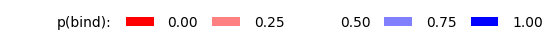

In [ ]:
#@title **Display Structure** (Colored by Confidence)
rescale_by_max_pbind = False
use_native_coordinates = True
show_ligand = False

if rescale_by_max_pbind:
  preds_adj = pred_bind.copy() / pred_bind.max()
else:
  preds_adj = pred_bind.copy()

# replace plddt and coordinates of prediction
L = af_model._target_len
aux = copy.deepcopy(af_model.aux["all"])
aux["plddt"][:,:L] = preds_adj
if show_ligand:
  af_model.save_pdb("output.pdb",aux={"all":aux})
else:
  aux["atom_mask"][:,L:] = 0
  x = {k:[] for k in ["aatype",
                      "residue_index",
                      "atom_positions",
                      "atom_mask",
                      "b_factors"]}
  asym_id = []
  for i in range(af_model._target_len):
    for k in ["aatype","atom_mask"]: x[k].append(aux[k][0,i])
    if use_native_coordinates:
      x["atom_positions"].append(af_model._pdb["batch"]["all_atom_positions"][i])
    else:
      x["atom_positions"].append(aux["atom_positions"][0,i])
    x["residue_index"].append(af_model._pdb["idx"]["residue"][i])
    x["b_factors"].append(x["atom_mask"][-1] * aux["plddt"][0,i] * 100.0)
    asym_id.append(af_model._pdb["idx"]["chain"][i])
  x = {k:np.array(v) for k,v in x.items()}

  # fix the chains
  (n,resnum_) = (0,None)
  pdb_lines = []
  for line in protein.to_pdb(protein.Protein(**x)).splitlines():
    if line[:4] == "ATOM":
      resnum = int(line[22:22+5])
      if resnum_ is None: resnum_ = resnum
      if resnum != resnum_:
        n += 1
        resnum_ = resnum
      pdb_lines.append("%s%s%4i%s" % (line[:21],asym_id[n],resnum,line[26:]))
  with open("output.pdb","w") as handle:
    handle.write("\n".join(pdb_lines))

hbondCutoff = 4.0
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',width=800,height=600)
pdb_str = open("output.pdb",'r').read()
view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
color_scheme = {'prop':'b','gradient': 'rwb','min':0,'max':100}
view.setStyle({'cartoon': {'colorscheme': color_scheme}})

# add sidechains
for i in range(af_model._target_len):
  c = af_model._pdb["idx"]["chain"][i]
  r = int(af_model._pdb["idx"]["residue"][i])
  p = pred_bind[i]
  if p > 0.5:
    view.addStyle({'and':[{'chain':c},{'resi':r},{'resn':["GLY","PRO"],'invert':True},{'atom':['C','O','N'],'invert':True}]},
                  {'stick':{'colorscheme':color_scheme,'radius':0.3}})
    view.addStyle({'and':[{'chain':c},{'resi':r},{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':color_scheme,'radius':0.3}})
    view.addStyle({'and':[{'chain':c},{'resi':r},{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':color_scheme,'radius':0.3}})

view.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel(atom.chain+"/"+atom.resi+"/"+atom.resn+" "+(atom.b/100.0).toFixed(3),{position:atom,backgroundColor:'white',backgroundOpacity:0.75,borderColor:'black',borderThickness:2.0,fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')

view.zoomTo()
view.show()

def plot_plddt_legend(dpi=100):
  thresh = ['p(bind):','0.00','0.25','0.50','0.75','1.00']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["white","#FF0000","#FF8080","#FFFFFF","#8080FF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
plot_plddt_legend().show()

In [ ]:
#@title **Download Predictions**
from google.colab import files
os.system(f"zip -r output.zip output.pdb results.csv")
files.download(f'output.zip')

##**Congratulation! That was basic but informative. You learned it**

If you happy for your time, Please provide your Support in the Form of a Subscription on Youtube Channel**

[**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg)

Follow [**WhatsApp Channel**](https://whatsapp.com/channel/0029VajkwkdCHDydS6Y2lM36) for further updates, research services, and courses.